In [1]:
# !pip uninstall snowflake -y

In [1]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector
from sklearn import preprocessing

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
import warnings
warnings.filterwarnings('ignore')

# 0. Read Training Data

In [5]:
import xgboost  
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold

In [6]:
training_data = pd.read_csv('latam_training_data.csv')

In [7]:
training_data.head()

,Unnamed: 0,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget,observed_medal,latam_home_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,days_from_theatrical,genre_Action,genre_Comedy,genre_Drama,genre_Fantasy & Sci-Fi,genre_Horror,genre_Kids & Family,genre_Music,genre_Not A Genre,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs
0,2,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Acquired,Action,2022-11-24,2022-03-17,"1,218,886.00","40,000,000.00",Silver,Silver,90.00,"1,107,532.00","7,058.00",8.84,0.20,252,1,0,0,0,0,0,0,0,0,0,0,1,2,12.79,20.08
1,3,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Acquired,Drama,2023-08-10,2023-03-16,"3,967.00","15,000,000.00",Bronze,Bronze,90.00,"34,968.00",226.00,0.30,0.01,147,0,0,1,0,0,0,0,0,1,0,0,0,3,7.82,15.09
2,7,Belfast,GYpn_UA8YyZ3DZgEAAAAW,0b926c5b-b8e4-401c-ba69-783ce07ad098,tt12789558,Acquired,Drama,2022-10-27,2022-03-10,"109,066.00","11,000,000.00",Bronze,Bronze,90.00,"137,179.00",522.00,1.13,0.02,231,0,0,1,0,0,0,0,0,1,0,0,0,3,9.03,17.07
3,8,Black Adam,GYzcHIw5407mRsAEAAAA4,0c730836-253b-4338-a3d1-a6a44a3384e0,tt6443346,Acquired,Action,2022-12-16,2022-10-20,"9,282,592.00","195,000,000.00",Platinum,Platinum,90.00,"5,705,318.00","208,837.00",44.64,5.42,57,1,0,0,0,0,0,0,0,0,0,1,0,0,17.67,22.44
4,15,Cry Macho,GYSbJuAuzchDCwgEAAAAC,b0598032-1cfd-4605-af5b-52ee492ce717,tt1924245,Acquired,Drama,2021-10-21,2021-10-21,"102,285.00","33,000,000.00",Silver,Silver,90.00,"672,638.00","8,395.00",7.85,0.30,0,0,0,1,0,0,0,0,0,0,0,0,1,2,13.04,19.36


In [9]:
training_data = training_data[training_data['first_release_date'] >= '2021-08-01']

In [10]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


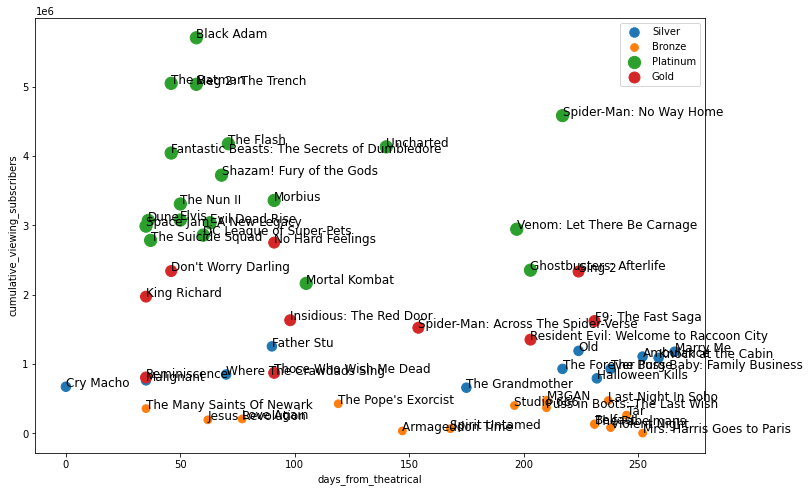

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_df = training_data
for i in training_data['latam_home_medal'].unique():
    plot_df = training_data[training_data['latam_home_medal'] == i]
    plt.scatter(plot_df['days_from_theatrical'], plot_df['cumulative_viewing_subscribers'], label=i, s = (5-plot_df['medal_number'])*30)

for i in training_data['ckg_series_id'].unique():
    plot_df = training_data[training_data['ckg_series_id'] == i]
    ax.text(plot_df['days_from_theatrical'].values[0], 
            plot_df['cumulative_viewing_subscribers'].values[0], 
            plot_df['title_series'].values[0], size=12)

ax.set_xlabel('days_from_theatrical')
ax.set_ylabel('cumulative_viewing_subscribers')
ax.legend()

plt.show()

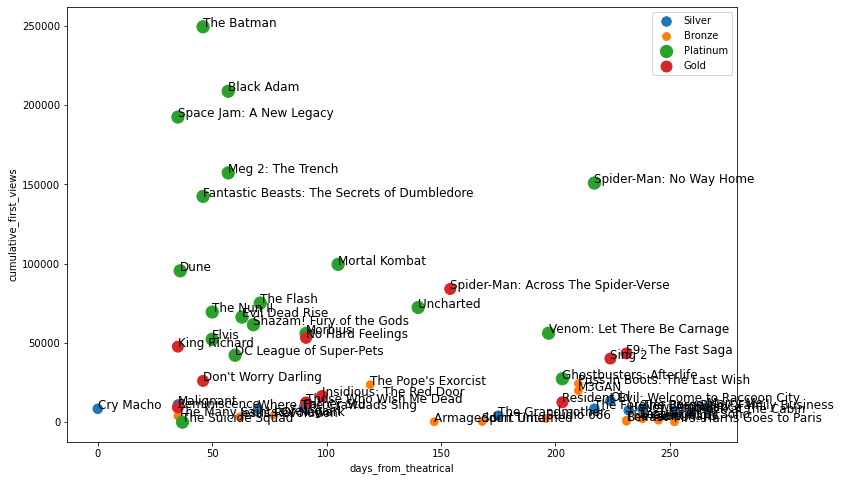

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_df = training_data
for i in training_data['latam_home_medal'].unique():
    plot_df = training_data[training_data['latam_home_medal'] == i]
    plt.scatter(plot_df['days_from_theatrical'], plot_df['cumulative_first_views'], label=i, s = (5-plot_df['medal_number'])*30)

for i in training_data['ckg_series_id'].unique():
    plot_df = training_data[training_data['ckg_series_id'] == i]
    ax.text(plot_df['days_from_theatrical'].values[0], 
            plot_df['cumulative_first_views'].values[0], 
            plot_df['title_series'].values[0], size=12)

ax.set_xlabel('days_from_theatrical')
ax.set_ylabel('cumulative_first_views')
ax.legend()

plt.show()

# 1. Viewing Subs

In [13]:
META_COLS = ['title_series', 'legacy_series_id', 'ckg_series_id', 'imdb_id', 'primary_genre', 'latam_home_medal', 'first_release_date', 'theatrical_date']

In [14]:
FEATURE_COLS = ['days_from_theatrical', 'area_gross', 'budget', 'genre_Action', 'medal_number'
                , 'genre_Comedy', 'genre_Drama']
                #, 'genre_Horror ', 'genre_Kids/Family', 'genre_Romance', 'genre_Sci-Fi', 'genre_Suspense/Thriller', 

In [15]:
# training_data['log_cumulative_viewing_subs'] = np.log10(training_data['cumulative_viewing_subscribers'])

In [16]:
TARGET_COL = ['cumulative_viewing_subscribers'] # log_cumulative_viewing_subs

In [17]:
training_data[META_COLS+FEATURE_COLS+TARGET_COL].head()

,title_series,legacy_series_id,ckg_series_id,imdb_id,primary_genre,latam_home_medal,first_release_date,theatrical_date,days_from_theatrical,area_gross,budget,genre_Action,medal_number,genre_Comedy,genre_Drama,cumulative_viewing_subscribers
0,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Action,Silver,2022-11-24,2022-03-17,252,"1,218,886.00","40,000,000.00",1,2,0,0,"1,107,532.00"
1,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Drama,Bronze,2023-08-10,2023-03-16,147,"3,967.00","15,000,000.00",0,3,0,1,"34,968.00"
2,Belfast,GYpn_UA8YyZ3DZgEAAAAW,0b926c5b-b8e4-401c-ba69-783ce07ad098,tt12789558,Drama,Bronze,2022-10-27,2022-03-10,231,"109,066.00","11,000,000.00",0,3,0,1,"137,179.00"
3,Black Adam,GYzcHIw5407mRsAEAAAA4,0c730836-253b-4338-a3d1-a6a44a3384e0,tt6443346,Action,Platinum,2022-12-16,2022-10-20,57,"9,282,592.00","195,000,000.00",1,0,0,0,"5,705,318.00"
4,Cry Macho,GYSbJuAuzchDCwgEAAAAC,b0598032-1cfd-4605-af5b-52ee492ce717,tt1924245,Drama,Silver,2021-10-21,2021-10-21,0,"102,285.00","33,000,000.00",0,2,0,1,"672,638.00"


In [18]:
training_data[training_data['title_series'].str.contains('Harris')]

,Unnamed: 0,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget,observed_medal,latam_home_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,days_from_theatrical,genre_Action,genre_Comedy,genre_Drama,genre_Fantasy & Sci-Fi,genre_Horror,genre_Kids & Family,genre_Music,genre_Not A Genre,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs
28,49,Mrs. Harris Goes to Paris,GZIHoeQqXaZOmPwEAAAyV,44d70775-f7a0-47d4-ad78-1a9fdc11a63a,tt5151570,Acquired,Comedy,2023-07-06,2022-10-27,"198,659.00","13,000,000.00",NaN,Bronze,90.00,"3,499.00",166.00,0.03,0.01,252,0,1,0,0,0,0,0,0,1,0,0,0,3,7.38,11.77


In [19]:
training_data = training_data[training_data['ckg_series_id']!= '44d70775-f7a0-47d4-ad78-1a9fdc11a63a'] 
#Excluding <Mrs. Harris Goes to Paris> cuz it has extremely low viewership

In [20]:
# training_data[np.isinf(training_data['cumulative_viewing_subscribers'])]
# training_data[FEATURE_COLS].isnull()

## 1.1 Cross Validation

In [21]:
def cal_error(validation_set):
    error_col = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]
    return error_col.mean()

In [22]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_antilog']-validation_set['cumulative_viewing_subscribers']).abs()/validation_set['cumulative_viewing_subscribers']
    return error_col.mean()

### 1.11 Random Forest CV - Benchmarking

In [23]:
num_folds = len(training_data['ckg_series_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)

In [24]:
num_folds

55

In [27]:
validation_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = GradientBoostingRegressor(random_state=0)

for train_index, test_index in group_kfold.split(training_data, groups=training_data['ckg_series_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
    print ("Validation Title: " + test_df['title_series'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

#         fi = model.feature_importances_
#         fi_df = pd.DataFrame([fi])
#         fi_df.columns = FEATURE_COLS
#         fi_df['match_id'] = test_df['match_id'].values[0]
#         fi_df['title_name'] = test_df['title_name'].values[0]
#         fi_df['days_on_hbo_max'] = day
#         feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

    except (KeyboardInterrupt, SystemExit):
        raise

    except Exception as ex:
        print(ex)
        print (test_df['title_series'].values[0] + " Failed!!")
        # raise

Validation Title: Love Again
Validation Title: Space Jam: A New Legacy
Validation Title: Where The Crawdads Sing
Validation Title: The Fabelmans
Validation Title: Tár
Validation Title: Evil Dead Rise
Validation Title: The Nun II
Validation Title: Those Who Wish Me Dead
Validation Title: Halloween Kills
Validation Title: Elvis
Validation Title: Puss in Boots: The Last Wish
Validation Title: The Flash
Validation Title: Jesus Revolution
Validation Title: Violent Night
Validation Title: The Boss Baby: Family Business
Validation Title: Mortal Kombat
Validation Title: Fantastic Beasts: The Secrets of Dumbledore
Validation Title: F9: The Fast Saga
Validation Title: Armageddon Time
Validation Title: Knock at the Cabin
Validation Title: The Suicide Squad
Validation Title: Last Night In Soho
Validation Title: Insidious: The Red Door
Validation Title: Black Adam
Validation Title: Belfast
Validation Title: Spider-Man: Across The Spider-Verse
Validation Title: Spirit Untamed
Validation Title: Venom

In [58]:
# validation_set.to_csv('validation_set.csv')

In [28]:
import shap

In [29]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

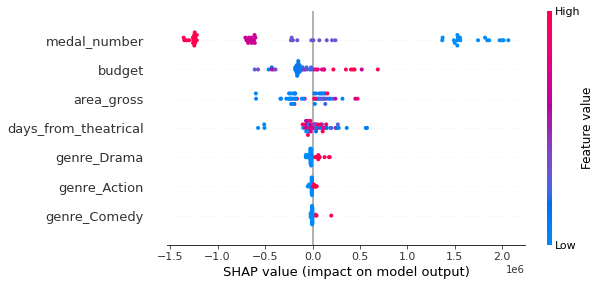

In [30]:
shap.summary_plot(shap_values, X_train)

In [31]:
cal_error(validation_set)

0.5982061419754576

In [32]:
# validation_set['pred_antilog'] = 2**(validation_set['pred'])

In [33]:
# cal_true_error(validation_set)

In [34]:
# validation_set['pct_error'] = (validation_set['pred_antilog']-validation_set['cumulative_viewing_subscribers']).abs()/validation_set['cumulative_viewing_subscribers']
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [35]:
validation_set[validation_set['pct_error']>2]

,Unnamed: 0,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget,observed_medal,latam_home_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,days_from_theatrical,genre_Action,genre_Comedy,genre_Drama,genre_Fantasy & Sci-Fi,genre_Horror,genre_Kids & Family,genre_Music,genre_Not A Genre,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs,pred,pct_error
0,94,Violent Night,GZKSpngBMw6d9XQEAAA8l,4b0ffcd7-1ebf-4b03-87c8-d5ac46d6aa0a,tt12003946,Acquired,Action,2023-07-27,2022-12-01,"728,319.00","20,000,000.00",Bronze,Bronze,90.00,"83,186.00","2,127.00",0.70,0.08,238,1,0,0,0,0,0,0,0,1,0,0,0,3,11.05,16.34,"412,123.17",3.95
0,3,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Acquired,Drama,2023-08-10,2023-03-16,"3,967.00","15,000,000.00",Bronze,Bronze,90.00,"34,968.00",226.00,0.30,0.01,147,0,0,1,0,0,0,0,0,1,0,0,0,3,7.82,15.09,"374,595.17",9.71
0,64,Spirit Untamed,GYfPcDwo9ccPDwwEAAAAD,GYfPcDwo9ccPDwwEAAAAD,tt11084896,Acquired,Comedy,2022-02-03,2021-08-19,"401,606.00","30,000,000.00",Bronze,Bronze,90.00,"67,563.00",387.00,0.68,0.01,168,0,1,0,0,0,0,0,0,1,0,0,0,3,8.60,16.04,"221,230.44",2.27


In [36]:
cal_error(validation_set)

0.5982061419754576

In [37]:
validation_set.groupby(['latam_home_medal']).pct_error.mean()

latam_home_medal
Bronze     1.63
Gold       0.27
Platinum   0.24
Silver     0.23
Name: pct_error, dtype: float64

### 1.12 Bayesian Regression CV

In [40]:
!pip install pygam

     |████████████████████████████████| 1.8 MB 21.4 MB/s            


In [42]:
from pygam import LinearGAM, s, f
from pygam import PoissonGAM
from pygam import LogisticGAM

In [43]:
FEATURE_COLS = ['days_from_theatrical', 'area_gross' , 'medal_number'
                 ,'genre_Comedy','genre_Action', 'budget', 'genre_Drama'
               ]
                #,'genre_Horror ', 'genre_Kids/Family', 'genre_Romance', 'genre_Sci-Fi', 'genre_Suspense/Thriller', ]

In [44]:
TARGET_COL = ['log_cumulative_viewing_subs'] # cumulative_first_views

In [45]:
num_folds = len(training_data['ckg_series_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)

In [46]:
num_folds

55

In [47]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)

days_from_theatrical   0.00
area_gross             0.00
medal_number           0.00
genre_Comedy           0.00
genre_Action           0.00
budget                 0.00
genre_Drama            0.00
dtype: float64

In [48]:
training_data['area_gross'] = training_data['area_gross'].fillna(0)
training_data['budget'] = training_data['budget'].fillna(0)

In [49]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['ckg_series_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

#         gam = LinearGAM(n_splines=10).fit(X_train, y_train)
        gam = LinearGAM(s(0) + s(1) + s(2)).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [50]:
cal_error(validation_set)

0.04220717586110839

In [51]:
validation_set['pred_antilog'] = 2**(validation_set['pred'])# - 10000

In [52]:
cal_true_error(validation_set)

973.9273431002227

In [161]:
# validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]
validation_set['pct_error'] = (validation_set['pred_antilog']-validation_set['cumulative_viewing_subscribers']).abs()/validation_set['cumulative_viewing_subscribers']

In [162]:
validation_set[validation_set['pct_error']>1][META_COLS+FEATURE_COLS+TARGET_COL+
                                              ['pred', 'cumulative_viewing_subscribers', 'percent_cumulative_viewing_subscribers'
                                               , 'pct_error']]

,title_series,legacy_series_id,ckg_series_id,imdb_id,primary_genre,latam_home_medal,first_release_date,theatrical_date,days_from_theatrical,area_gross,genre_Drama,medal_number,log_cumulative_viewing_subs,pred,cumulative_viewing_subscribers,percent_cumulative_viewing_subscribers,pct_error
0,Spirit Untamed,GYfPcDwo9ccPDwwEAAAAD,GYfPcDwo9ccPDwwEAAAAD,tt11084896,Comedy,Bronze,2022-02-03,2021-08-19,168,"401,606.00",0,3,16.04,17.45,"67,563.00",0.68,1.65
0,Violent Night,GZKSpngBMw6d9XQEAAA8l,4b0ffcd7-1ebf-4b03-87c8-d5ac46d6aa0a,tt12003946,Action,Bronze,2023-07-27,2022-12-01,238,"728,319.00",0,3,16.34,18.00,"83,186.00",0.70,2.16
0,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Drama,Bronze,2023-08-10,2023-03-16,147,"3,967.00",1,3,15.09,17.71,"34,968.00",0.30,5.13
0,Reminiscence,GYQBEaQwta8PCAAEAAAA-,e96a64f5-d1cd-491e-ad4b-8eb9200b7437,tt3272066,Fantasy & Sci-Fi,Gold,2021-09-23,2021-08-19,35,"354,800.00",0,1,19.62,20.71,"806,082.00",10.49,1.13
0,Spider-Man: No Way Home,GYqeASQeezEo8igEAAACK,GYqeASQeezEo8igEAAACK,tt10872600,Action,Platinum,2022-07-21,2021-12-16,217,"46,191,154.00",0,0,22.13,23.95,"4,582,838.00",38.38,2.54


In [163]:
FEATURE_COLS

['days_from_theatrical', 'area_gross', 'genre_Drama', 'medal_number']

In [51]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [52]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.4964
Link Function:                     IdentityLink Log Likelihood:                                   -63.2564
Number of Samples:                           61 AIC:                                              149.5055
                                                AICc:                                             155.4294
                                                GCV:                                                0.5992
                                                Scale:                                              0.4171
                                                Pseudo R-Squared:                                   0.8739
Feature Function                  Lam

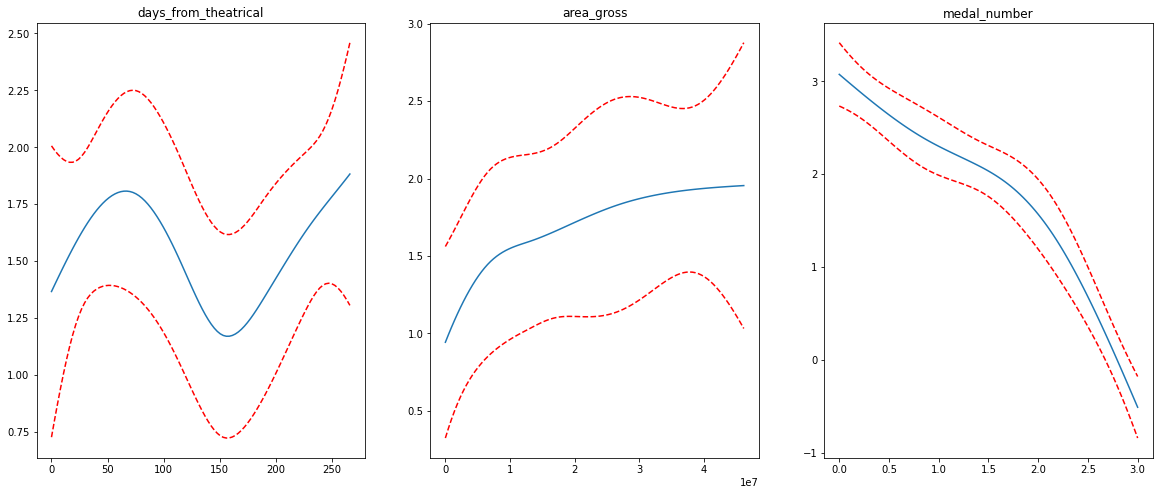

In [54]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 3)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [ ]:
validation_set.groupby(['latam_home_medal']).pct_error.mean()

### 1.13 Bayesian Regression Scoring

#####1.131 Scoring 1

In [53]:
training_data.head()

,Unnamed: 0,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget,observed_medal,latam_home_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,days_from_theatrical,genre_Action,genre_Comedy,genre_Drama,genre_Fantasy & Sci-Fi,genre_Horror,genre_Kids & Family,genre_Music,genre_Not A Genre,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs
0,2,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Acquired,Action,2022-11-24,2022-03-17,"1,218,886.00","40,000,000.00",Silver,Silver,90.00,"1,107,532.00","7,058.00",8.84,0.20,252,1,0,0,0,0,0,0,0,0,0,0,1,2,12.79,20.08
1,3,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Acquired,Drama,2023-08-10,2023-03-16,"3,967.00","15,000,000.00",Bronze,Bronze,90.00,"34,968.00",226.00,0.30,0.01,147,0,0,1,0,0,0,0,0,1,0,0,0,3,7.82,15.09
2,7,Belfast,GYpn_UA8YyZ3DZgEAAAAW,0b926c5b-b8e4-401c-ba69-783ce07ad098,tt12789558,Acquired,Drama,2022-10-27,2022-03-10,"109,066.00","11,000,000.00",Bronze,Bronze,90.00,"137,179.00",522.00,1.13,0.02,231,0,0,1,0,0,0,0,0,1,0,0,0,3,9.03,17.07
3,8,Black Adam,GYzcHIw5407mRsAEAAAA4,0c730836-253b-4338-a3d1-a6a44a3384e0,tt6443346,Acquired,Action,2022-12-16,2022-10-20,"9,282,592.00","195,000,000.00",Platinum,Platinum,90.00,"5,705,318.00","208,837.00",44.64,5.42,57,1,0,0,0,0,0,0,0,0,0,1,0,0,17.67,22.44
4,15,Cry Macho,GYSbJuAuzchDCwgEAAAAC,b0598032-1cfd-4605-af5b-52ee492ce717,tt1924245,Acquired,Drama,2021-10-21,2021-10-21,"102,285.00","33,000,000.00",Silver,Silver,90.00,"672,638.00","8,395.00",7.85,0.30,0,0,0,1,0,0,0,0,0,0,0,0,1,2,13.04,19.36


In [54]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=7).fit(X, y)
# gam = GradientBoostingRegressor(random_state=0).fit(X, y)

In [55]:
# explainer = shap.Explainer(gam)
# shap_values = explainer.shap_values(X)
# shap.summary_plot(shap_values, X)

In [56]:
# gam.summary()

In [57]:
pred_day = [*range(0, 200, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical'])

In [58]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical'], axis = 1, inplace = True)

In [59]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

In [60]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [61]:
scoring_data.head()

,title_series,legacy_series_id,ckg_series_id,imdb_id,primary_genre,latam_home_medal,first_release_date,theatrical_date,area_gross,medal_number,genre_Comedy,genre_Action,budget,genre_Drama,days_from_theatrical
0,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Action,Silver,2022-11-24,2022-03-17,"1,218,886.00",2,0,1,"40,000,000.00",0,0
1,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Action,Silver,2022-11-24,2022-03-17,"1,218,886.00",2,0,1,"40,000,000.00",0,15
2,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Action,Silver,2022-11-24,2022-03-17,"1,218,886.00",2,0,1,"40,000,000.00",0,30
3,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Action,Silver,2022-11-24,2022-03-17,"1,218,886.00",2,0,1,"40,000,000.00",0,45
4,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Action,Silver,2022-11-24,2022-03-17,"1,218,886.00",2,0,1,"40,000,000.00",0,60


In [62]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [63]:
# scoring_data

In [64]:
scoring_data['kpi'] = 'viewing_subs'

In [65]:
scoring_data_45 = scoring_data[scoring_data['days_from_theatrical'] == 45][['ckg_series_id', 'pred']].rename(columns = {'pred':'pred_45'})

In [66]:
scoring_data = scoring_data.merge(scoring_data_45, on = ['ckg_series_id'])

In [67]:
scoring_data['multiplier'] = scoring_data['pred']/scoring_data['pred_45']

In [68]:
score_multi = scoring_data.groupby(['latam_home_medal', 'days_from_theatrical']).mean()[['multiplier']].reset_index()

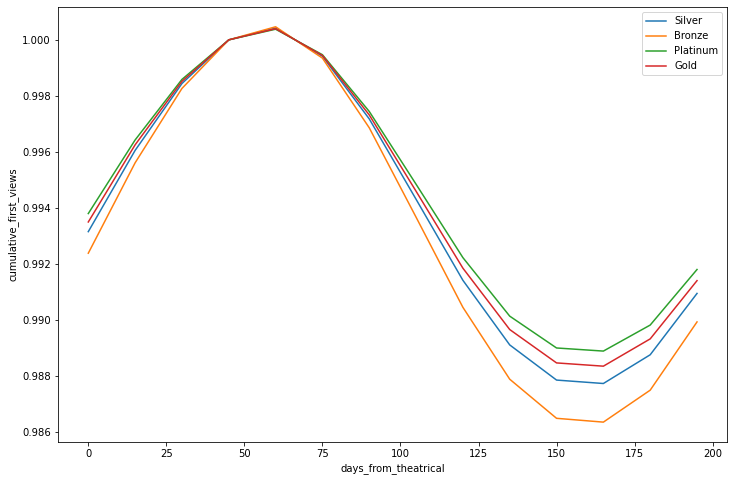

In [69]:
fig, ax = plt.subplots(figsize=(12, 8))
for i in training_data['latam_home_medal'].unique():
    plot_df = score_multi[score_multi['latam_home_medal'] == i]
    plt.plot(plot_df['days_from_theatrical'], plot_df['multiplier'], label=i)


ax.set_xlabel('days_from_theatrical')
ax.set_ylabel('cumulative_first_views')
ax.legend()

plt.show()

In [70]:
OUTPUT_COLS = ['title_id', 'imdb_id', 'title', 'home_territory_observed_medal', 'pillar_genres', 'area_gross', 'medal_number', 'budget', 
              'days_from_theatrical2', 'kpi', 'pred']

In [74]:
# write_to_sf(scoring_data[OUTPUT_COLS], 'title_level_subs')

In [73]:
# import plotly.express as px

In [1]:
# plot_df = scoring_data
# fig = px.line(plot_df, x="days_from_theatrical2", y="pred", color = 'title',
#               title='Release day V.S. cumulative viewership')
# fig.show()

##### 1.132 Scoring2

In [115]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical'], axis = 1, inplace = True)

In [116]:
scoring_data = scoring_data.groupby(['latam_home_medal', 'primary_genre']).mean().reset_index()

In [118]:
pred_day = [*range(0, 200, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical'])

In [119]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [120]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [121]:
scoring_data.head()

,latam_home_medal,primary_genre,area_gross,budget,genre_Action,medal_number,genre_Comedy,genre_Drama,days_from_theatrical,pred
0,Bronze,Action,"728,319.00","20,000,000.00",1,3,0,0,0,"-37,234.15"
1,Bronze,Action,"728,319.00","20,000,000.00",1,3,0,0,15,"-37,234.15"
2,Bronze,Action,"728,319.00","20,000,000.00",1,3,0,0,30,"-35,660.81"
3,Bronze,Action,"728,319.00","20,000,000.00",1,3,0,0,45,"277,473.85"
4,Bronze,Action,"728,319.00","20,000,000.00",1,3,0,0,60,"4,334.91"


In [90]:
scoring_data['title_id'] = np.NAN
scoring_data['imdb_id'] = np.NAN
scoring_data['title'] = np.NAN
scoring_data['kpi'] = 'viewing_subs'

In [91]:
write_to_sf(scoring_data[OUTPUT_COLS], 'genre_level_subs')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



# 2. First Views

In [92]:
# medal_onehot = pd.get_dummies(training_data['home_territory_observed_medal'], prefix='medal')
# training_data=pd.concat([training_data, medal_onehot], axis = 1)

In [75]:
training_data[training_data['title_series'].str.contains('Wonder')]

,Unnamed: 0,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget,observed_medal,latam_home_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,days_from_theatrical,genre_Action,genre_Comedy,genre_Drama,genre_Fantasy & Sci-Fi,genre_Horror,genre_Kids & Family,genre_Music,genre_Not A Genre,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs


In [76]:
training_data = training_data[(training_data['cumulative_first_views'].notnull())
                             &(training_data['cumulative_first_views']>0)
                             &(training_data['days_from_theatrical']>0)
                             &~(training_data['ckg_series_id'].isin(['f1c6ef16-40b2-4ef5-89ed-547decd9e620',
                                                                    '4296565c-c6c9-4b81-9398-fdf996e7d925']))]
training_data['log_cumulative_first_views'] = np.log2(training_data['cumulative_first_views']+10000)

In [77]:
# training_data['power_cumulative_first_views'] = np.power(training_data['cumulative_first_views'], (1/4))

In [78]:
META_COLS = ['title_series', 'legacy_series_id', 'ckg_series_id', 'imdb_id', 'primary_genre', 'latam_home_medal', 'first_release_date', 'theatrical_date']

In [79]:
FEATURE_COLS = ['days_from_theatrical', 'area_gross', 'budget' , 'genre_Action', 'genre_Comedy', 'genre_Drama', 'medal_number']
                #, 'genre_Horror ', 'genre_Kids/Family', 'genre_Romance', 'genre_Sci-Fi', 'genre_Suspense/Thriller', 'medal_Bronze', 'medal_Gold'

In [80]:
TARGET_COL = ['log_cumulative_first_views'] # cumulative_first_views

In [81]:
TARGET_COL

['log_cumulative_first_views']

## 2.1 Cross Validation

In [82]:
def cal_error(validation_set):
    error_col = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]].abs()
    return error_col.mean()

### 2.11 Random Forest CV

In [83]:
num_folds = len(training_data['ckg_series_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)

In [84]:
num_folds

53

In [85]:
validation_set = pd.DataFrame()
feature_importances = pd.DataFrame()
# model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model = GradientBoostingRegressor(random_state=0)


for train_index, test_index in group_kfold.split(training_data, groups=training_data['ckg_series_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title_series'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

        fi = model.feature_importances_
        fi_df = pd.DataFrame([fi])
        fi_df.columns = FEATURE_COLS
        fi_df['ckg_series_id'] = test_df['ckg_series_id'].values[0]
        fi_df['title_series'] = test_df['title_series'].values[0]
        feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

    except Exception as e:
        print (e)

In [86]:
# validation_set.to_csv('validation_set.csv')

In [87]:
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [89]:
validation_set[validation_set['pct_error']>2][META_COLS + ['days_from_theatrical', 'budget', 'area_gross', 'pred'] + TARGET_COL]

,title_series,legacy_series_id,ckg_series_id,imdb_id,primary_genre,latam_home_medal,first_release_date,theatrical_date,days_from_theatrical,budget,area_gross,pred,log_cumulative_first_views


In [90]:
cal_error(validation_set) #0.062

0.02603523016936181

In [91]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_antilog']-validation_set['cumulative_first_views']).abs()/validation_set['cumulative_first_views']
    return error_col.mean()

In [92]:
validation_set['pred_antilog'] = 2**validation_set['pred'] - 10000

In [93]:
validation_set['pct_error'] = (validation_set['pred_antilog']-validation_set['cumulative_first_views']).abs()/validation_set['cumulative_first_views']

In [94]:
cal_true_error(validation_set)

0.7354200021132263

In [95]:
feature_importances.mean()

days_from_theatrical   0.03
area_gross             0.11
budget                 0.13
genre_Action           0.00
genre_Comedy           0.00
genre_Drama            0.00
medal_number           0.73
dtype: float64

### 2.12 Bayesian Regression CV

In [96]:
# !pip install pygam

In [97]:
from pygam import LinearGAM, s, PoissonGAM

In [98]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)

days_from_theatrical   0.00
area_gross             0.00
budget                 0.00
genre_Action           0.00
genre_Comedy           0.00
genre_Drama            0.00
medal_number           0.00
dtype: float64

In [99]:
training_data['area_gross'] = training_data['area_gross'].fillna(0)
training_data['budget'] = training_data['budget'].fillna(0)

In [152]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['ckg_series_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model|
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=4).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [153]:
cal_error(validation_set) # 0.035

0.030053734450991017

In [154]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_antilog']-validation_set['cumulative_first_views']).abs()/validation_set['cumulative_first_views']
    return error_col.mean()

In [155]:
validation_set['pred_antilog'] = 2**(validation_set['pred']) - 10000

In [156]:
cal_true_error(validation_set)

0.9560660287546167

In [105]:
validation_set['pct_error'] = (validation_set['pred_antilog']-validation_set['cumulative_first_views']).abs()/validation_set['cumulative_first_views']

In [106]:
validation_set[validation_set['pct_error']>2][['days_from_theatrical', 'budget', 'area_gross', 'pred'] + TARGET_COL]

,days_from_theatrical,budget,area_gross,pred,log_cumulative_first_views
0,231,"40,000,000.00","418,272.00",13.75,13.45
0,147,"15,000,000.00","3,967.00",13.86,13.32
0,168,"30,000,000.00","401,606.00",13.99,13.34
0,35,"54,000,000.00","354,800.00",15.70,14.24
0,217,"200,000,000.00","46,191,154.00",21.24,17.30


In [107]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [108]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     14.1987
Link Function:                     IdentityLink Log Likelihood:                                   -49.0718
Number of Samples:                           53 AIC:                                               128.541
                                                AICc:                                              141.921
                                                GCV:                                                0.5902
                                                Scale:                                              0.3149
                                                Pseudo R-Squared:                                   0.8694
Feature Function                  Lam

In [109]:
import matplotlib.pyplot as plt

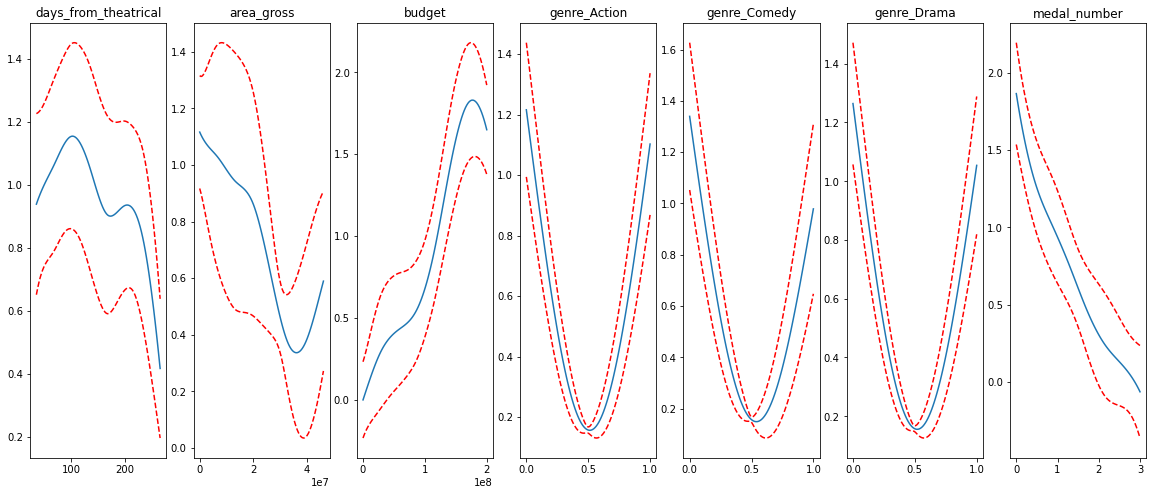

In [110]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 7)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

### 2.13 GAM Scoring

##### 2.131 Scoring 1

In [113]:
training_data.head()

,Unnamed: 0,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget,observed_medal,latam_home_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,days_from_theatrical,genre_Action,genre_Comedy,genre_Drama,genre_Fantasy & Sci-Fi,genre_Horror,genre_Kids & Family,genre_Music,genre_Not A Genre,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs
0,2,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Acquired,Action,2022-11-24,2022-03-17,"1,218,886.00","40,000,000.00",Silver,Silver,90.00,"1,107,532.00","7,058.00",8.84,0.20,252,1,0,0,0,0,0,0,0,0,0,0,1,2,14.06,20.08
1,3,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Acquired,Drama,2023-08-10,2023-03-16,"3,967.00","15,000,000.00",Bronze,Bronze,90.00,"34,968.00",226.00,0.30,0.01,147,0,0,1,0,0,0,0,0,1,0,0,0,3,13.32,15.09
2,7,Belfast,GYpn_UA8YyZ3DZgEAAAAW,0b926c5b-b8e4-401c-ba69-783ce07ad098,tt12789558,Acquired,Drama,2022-10-27,2022-03-10,"109,066.00","11,000,000.00",Bronze,Bronze,90.00,"137,179.00",522.00,1.13,0.02,231,0,0,1,0,0,0,0,0,1,0,0,0,3,13.36,17.07
3,8,Black Adam,GYzcHIw5407mRsAEAAAA4,0c730836-253b-4338-a3d1-a6a44a3384e0,tt6443346,Acquired,Action,2022-12-16,2022-10-20,"9,282,592.00","195,000,000.00",Platinum,Platinum,90.00,"5,705,318.00","208,837.00",44.64,5.42,57,1,0,0,0,0,0,0,0,0,0,1,0,0,17.74,22.44
5,16,DC League of Super-Pets,GYw48owR8pBbDwwEAAAh0,01eec62a-f4cd-43b9-a07b-a4ead7ffc089,tt8912936,Acquired,Kids & Family,2022-09-26,2022-07-28,"4,649,313.00","90,000,000.00",Platinum,Platinum,90.00,"2,859,293.00","42,193.00",24.41,1.52,60,0,0,0,0,0,1,0,0,0,0,1,0,0,15.67,21.45


In [114]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

In [157]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=4).fit(X, y)
# gam = GradientBoostingRegressor(random_state=0).fit(X, y)

In [172]:
pred_day = [*range(0, 200, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical'])

scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical'], axis = 1, inplace = True)

scoring_data=cartesian_product_basic(scoring_data, df)

In [173]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [174]:
scoring_data['pred'] = 2**(scoring_data['pred']) - 10000
scoring_data['kpi'] = 'first_views'

scoring_data_45 = scoring_data[scoring_data['days_from_theatrical'] == 45][['ckg_series_id', 'pred']].rename(columns = {'pred':'base'}).copy()
scoring_data = scoring_data.merge(scoring_data_45, on = ['ckg_series_id'])
scoring_data['multiplier'] = scoring_data['pred']/scoring_data['base']

score_multi = scoring_data.groupby(['latam_home_medal', 'days_from_theatrical']).mean()[['multiplier']].reset_index()

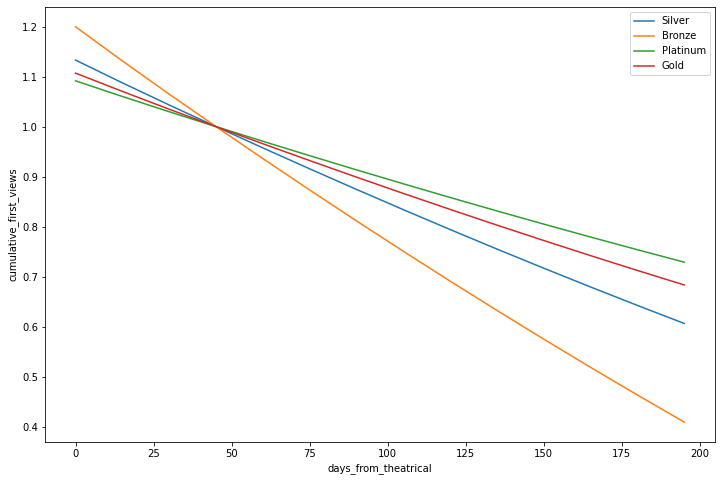

In [175]:
fig, ax = plt.subplots(figsize=(12, 8))
for i in training_data['latam_home_medal'].unique():
    plot_df = score_multi[score_multi['latam_home_medal'] == i]
    plt.plot(plot_df['days_from_theatrical'], plot_df['multiplier'], label=i)


ax.set_xlabel('days_from_theatrical')
ax.set_ylabel('cumulative_first_views')
ax.legend()

plt.show()

In [167]:
# write_to_sf(scoring_data[OUTPUT_COLS], 'title_level_first_views')
scoring_data.to_csv('latam_results_table.csv')

##### 1.132 Scoring2

In [118]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical'], axis = 1, inplace = True)

In [119]:
scoring_data.head()

,title_series,legacy_series_id,ckg_series_id,imdb_id,primary_genre,latam_home_medal,first_release_date,theatrical_date,area_gross,budget,genre_Action,genre_Comedy,genre_Drama,medal_number
0,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Action,Silver,2022-11-24,2022-03-17,"1,218,886.00","40,000,000.00",1,0,0,2
1,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Drama,Bronze,2023-08-10,2023-03-16,"3,967.00","15,000,000.00",0,0,1,3
2,Belfast,GYpn_UA8YyZ3DZgEAAAAW,0b926c5b-b8e4-401c-ba69-783ce07ad098,tt12789558,Drama,Bronze,2022-10-27,2022-03-10,"109,066.00","11,000,000.00",0,0,1,3
3,Black Adam,GYzcHIw5407mRsAEAAAA4,0c730836-253b-4338-a3d1-a6a44a3384e0,tt6443346,Action,Platinum,2022-12-16,2022-10-20,"9,282,592.00","195,000,000.00",1,0,0,0
5,DC League of Super-Pets,GYw48owR8pBbDwwEAAAh0,01eec62a-f4cd-43b9-a07b-a4ead7ffc089,tt8912936,Kids & Family,Platinum,2022-09-26,2022-07-28,"4,649,313.00","90,000,000.00",0,0,0,0


In [120]:
scoring_data = scoring_data.groupby(['latam_home_medal', 'primary_genre']).mean().reset_index()

In [121]:
pred_day = [*range(0, 200, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical'])

In [122]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [123]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [127]:
scoring_data.head()

,latam_home_medal,primary_genre,area_gross,budget,genre_Action,genre_Comedy,genre_Drama,medal_number,days_from_theatrical,pred,title_id,imdb_id,title,kpi
0,Bronze,Action,"728,319.00","20,000,000.00",1,0,0,3,0,"8,282.70",nan,nan,nan,first_views
1,Bronze,Action,"728,319.00","20,000,000.00",1,0,0,3,15,"8,238.79",nan,nan,nan,first_views
2,Bronze,Action,"728,319.00","20,000,000.00",1,0,0,3,30,"8,194.98",nan,nan,nan,first_views
3,Bronze,Action,"728,319.00","20,000,000.00",1,0,0,3,45,"8,141.46",nan,nan,nan,first_views
4,Bronze,Action,"728,319.00","20,000,000.00",1,0,0,3,60,"8,057.86",nan,nan,nan,first_views


In [125]:
scoring_data['title_id'] = np.NAN
scoring_data['imdb_id'] = np.NAN
scoring_data['title'] = np.NAN
scoring_data['kpi'] = 'first_views'

In [126]:
scoring_data['pred'] = 2**scoring_data['pred'] - 10000

In [129]:
scoring_data_45 = scoring_data[scoring_data['days_from_theatrical'] == 45][['latam_home_medal', 'primary_genre', 'pred']].rename(columns = {'pred':'base'}).copy()
scoring_data = scoring_data.merge(scoring_data_45, on = ['latam_home_medal', 'primary_genre'])
scoring_data['multiplier'] = scoring_data['pred']/scoring_data['base']

In [135]:
score_multi = scoring_data.groupby(['primary_genre', 'days_from_theatrical']).mean()[['multiplier']].reset_index()

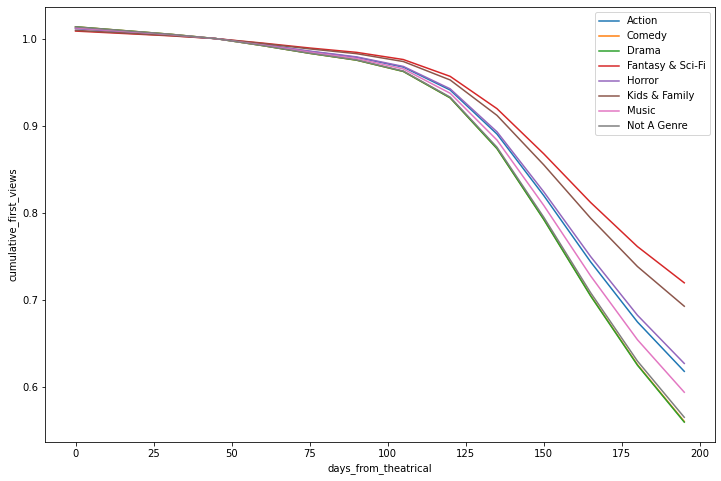

In [136]:
fig, ax = plt.subplots(figsize=(12, 8))
for i in score_multi['primary_genre'].unique():
    plot_df = score_multi[score_multi['primary_genre'] == i]
    plt.plot(plot_df['days_from_theatrical'], plot_df['multiplier'], label=i)


ax.set_xlabel('days_from_theatrical')
ax.set_ylabel('cumulative_first_views')
ax.legend()

plt.show()

In [143]:
write_to_sf(scoring_data[OUTPUT_COLS], 'genre_level_first_views')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



# WRITE TO SF

In [5]:
import boto3
import io

In [6]:
def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)

In [7]:
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [8]:
def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'movie_windowing/movie_window_prediction_{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

In [9]:
OUTPUT_COLS = ['title_id', 'imdb_id', 'title', 'home_territory_observed_medal', 'pillar_genres', 'area_gross', 'medal_number', 'budget', 'days_from_theatrical2', 'kpi', 'pred']

In [10]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [154]:
run_query('''
create or replace table max_dev.workspace.movie_window_prediction_title_level_subs
(
title_id	VARCHAR,
imdb_id	VARCHAR,
title	VARCHAR,
home_territory_observed_medal	VARCHAR,
pillar_genres	VARCHAR,
area_gross	FLOAT,
medal_number	INT,
budget	FLOAT,
days_from_theatrical2	INT,
kpi	VARCHAR,
pred FLOAT
);

''')


,status
0,Table MOVIE_WINDOW_PREDICTION_TITLE_LEVEL_SUBS...


In [18]:
# run_query('''
# create or replace table max_dev.workspace.movie_window_prediction_actual_value
# (
# title_id	VARCHAR,
# days_from_theatrical2 int,
# value FLOAT,
# kpi	VARCHAR
# );

# ''')

,status
0,Table MOVIE_WINDOW_PREDICTION_ACTUAL_VALUE suc...


In [ ]:
#first_views #genre_level_first_views

In [155]:
run_query('''
copy into max_dev.workspace.movie_window_prediction_title_level_subs
    from(
        select
              $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11
        from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/movie_windowing/movie_window_prediction_title_level_subs.csv
        )
    file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
    on_error = 'CONTINUE';

''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/movi...,LOADED,1022,1022,1022,0,None,None,None,None


In [19]:
# run_query('''
# copy into max_dev.workspace.movie_window_prediction_actual_value
#     from(
#         select
#               $1, $2, $3, $4
#         from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/movie_windowing/movie_window_prediction_actual_value.csv
#         )
#     file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
#     on_error = 'CONTINUE';

# ''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/movi...,LOADED,206,206,206,0,None,None,None,None


In [189]:
training_data.head()

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_number,platform,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,log_cumulative_first_views
0,0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,2020-12-25,2021-09-05,250,0.09,-219,2557041,25362,"2,250,430.00","38,000,000.00",1,0,0,0,0,0,0,0,2,1.00,0,0,0,1,14.63
3,3,GYbzvWABDj8LDwgEAAAAp,The Last Duel,Gold,Drama,tt4244994,2021-10-15,2022-01-14,91,0.16,-513,5012315,33314,"4,759,151.00","100,000,000.00",0,0,1,0,0,0,0,0,1,1.00,0,1,0,0,15.02
4,4,GYm0w5wSRXaTDYQEAAAD4,Last Night in Soho,Silver,Suspense/Thriller,tt9639470,2021-10-29,2022-07-01,245,0.07,-527,2005376,8975,"4,178,460.00","43,000,000.00",0,0,0,0,0,0,0,1,2,1.00,0,0,0,1,13.13
6,6,GYd9P0QTRLMLDJwEAAAAP,Antlers,Silver,Horror,tt7740510,2021-10-11,2022-02-11,123,0.09,-509,2614867,14444,"4,271,346.00",0.00,0,0,0,1,0,0,0,0,2,1.00,0,0,0,1,13.82
7,7,GYfinBwyKBImYsgEAAACn,Halloween Kills,Silver,Horror,tt10665338,2021-10-15,2022-03-18,137,0.10,-513,2838005,28030,"49,404,980.00","20,000,000.00",0,0,0,1,0,0,0,0,2,1.00,0,0,0,1,14.77


In [15]:
df1 = training_data[['title_id', 'days_from_theatrical2', 'cumulative_viewing_subs']].rename(columns = {'cumulative_viewing_subs':'value'})
df1['kpi'] = 'viewing_subs'
df2 = training_data[['title_id', 'days_from_theatrical2', 'cumulative_first_views']].rename(columns = {'cumulative_first_views':'value'})
df2['kpi'] = 'first_views'
actual_data = pd.concat([df1, df2], axis = 0)

In [16]:
write_to_sf(actual_data, 'actual_value')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [1]:
actual_data.tail()

NameError: name 'actual_data' is not defined